In [3]:
import numpy as np
import json
import pandas as pd
from collections import Counter
%matplotlib inline
import scipy as sp
from scipy import concatenate
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
pd.options.display.max_columns = 100

# Data Exploration

Using the data that we already have, we clean it in order to run a Random Forest. First, we create a new column that identifies the data by year (Later on, we are going to fit the model to the 2013 data and predict on the 2014 data). We create a dictionary of PLAYER1_ID and TEAM_ID, in case we need to access these values later.

In [4]:
data_2014 = pd.read_csv("merged_shots/merged_shots_14.csv")
data_2013 = pd.read_csv("merged_shots/merged_shots_13.csv")

In [5]:
data_2014['YEAR'] = 2014
data_2013['YEAR'] = 2013

Here we combine our data into 1 large dataframe, and check columns to see the percentage of null values

In [6]:
frames = [data_2013,data_2014]
combined = pd.concat(frames)

combined["unique"] = range(0,len(combined))
for i, c in enumerate(combined.isnull().sum()/combined.shape[0]):
    if c != 0:
        print combined.columns[i], c

HOMEDESCRIPTION 0.471027036451
NEUTRALDESCRIPTION 1.0
PLAYER2_NAME 0.735540915827
PLAYER2_TEAM_ABBREVIATION 0.735540915827
PLAYER2_TEAM_CITY 0.735540915827
PLAYER2_TEAM_ID 0.735540915827
PLAYER2_TEAM_NICKNAME 0.735540915827
PLAYER3_NAME 0.943737780047
PLAYER3_TEAM_ABBREVIATION 0.943737780047
PLAYER3_TEAM_CITY 0.943737780047
PLAYER3_TEAM_ID 0.943737780047
PLAYER3_TEAM_NICKNAME 0.943737780047
SCORE 0.548056638314
VISITORDESCRIPTION 0.472710743596
HOME_TEAM_ID 0.0979165369432
AWAY_TEAM_ID 0.0979165369432
HOME_PLAYER1_ID 0.0979165369432
HOME_PLAYER2_ID 0.0979165369432
HOME_PLAYER3_ID 0.0979165369432
HOME_PLAYER4_ID 0.0979165369432
HOME_PLAYER5_ID 0.0979165369432
AWAY_PLAYER1_ID 0.0979165369432
AWAY_PLAYER2_ID 0.0979165369432
AWAY_PLAYER3_ID 0.0979165369432
AWAY_PLAYER4_ID 0.0979165369432
AWAY_PLAYER5_ID 0.0979165369432
SHOT_CLOCK 0.0519234361574
off_height 0.0205556731715
def_height 0.0239355409158


Here we create dictionaries of the players unique id number and their name.

In [7]:
a = np.concatenate((combined.PLAYER1_NAME, combined.PLAYER2_NAME))
b = np.concatenate((combined.PLAYER1_ID, combined.PLAYER2_ID))

In [8]:
player_id_dict = {k : v for k, v in zip(b, a)}
team_id_dict = {int(k) : v1+" "+v2 for k, v1, v2 in zip(combined.PLAYER1_TEAM_ID, combined.PLAYER1_TEAM_CITY, combined.PLAYER1_TEAM_NICKNAME)}

In [9]:
defender_id_dict = {int(k) : v for k, v in zip(combined.CLOSEST_DEFENDER_PLAYER_ID, combined.CLOSEST_DEFENDER)}

In [10]:
for p in defender_id_dict.keys():
    temp = p in player_id_dict.keys()
    if not temp:
        splt = defender_id_dict[p].split(",")
        player_id_dict[p] = splt[1]+" "+splt[0]

Now we remove columns that have superflous data, or that can be calculated from some other column

In [11]:
for i, c in enumerate(combined.columns):
        print i, ":", c

0 : Unnamed: 0
1 : EVENTMSGACTIONTYPE
2 : EVENTMSGTYPE
3 : EVENTNUM
4 : GAME_ID
5 : HOMEDESCRIPTION
6 : NEUTRALDESCRIPTION
7 : PCTIMESTRING
8 : PERIOD_x
9 : PERSON1TYPE
10 : PERSON2TYPE
11 : PERSON3TYPE
12 : PLAYER1_ID
13 : PLAYER1_NAME
14 : PLAYER1_TEAM_ABBREVIATION
15 : PLAYER1_TEAM_CITY
16 : PLAYER1_TEAM_ID
17 : PLAYER1_TEAM_NICKNAME
18 : PLAYER2_ID
19 : PLAYER2_NAME
20 : PLAYER2_TEAM_ABBREVIATION
21 : PLAYER2_TEAM_CITY
22 : PLAYER2_TEAM_ID
23 : PLAYER2_TEAM_NICKNAME
24 : PLAYER3_ID
25 : PLAYER3_NAME
26 : PLAYER3_TEAM_ABBREVIATION
27 : PLAYER3_TEAM_CITY
28 : PLAYER3_TEAM_ID
29 : PLAYER3_TEAM_NICKNAME
30 : SCORE
31 : SCOREMARGIN
32 : VISITORDESCRIPTION
33 : WCTIMESTRING
34 : HOME_TEAM_ID
35 : AWAY_TEAM_ID
36 : HOME_PLAYER1_ID
37 : HOME_PLAYER2_ID
38 : HOME_PLAYER3_ID
39 : HOME_PLAYER4_ID
40 : HOME_PLAYER5_ID
41 : AWAY_PLAYER1_ID
42 : AWAY_PLAYER2_ID
43 : AWAY_PLAYER3_ID
44 : AWAY_PLAYER4_ID
45 : AWAY_PLAYER5_ID
46 : ACTION_BEFORE
47 : Unnamed: 0.1
48 : CLOSEST_DEFENDER
49 : CLOSEST_D

In [12]:
col_dict = {x: col for x, col in enumerate(combined.columns)}
col_list = [0,1,2,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,49,52,53,54,55,57,58,59,60,63,65,67,71,68,76,73,78,79,80,81,85,90]
drop = [col_dict[x] for x in col_list]

In [13]:
combined_ = combined.drop(drop, axis=1)

In [14]:
for i, c in enumerate(combined_.columns):
        print i, ":", c

0 : EVENTNUM
1 : PERIOD_x
2 : SCOREMARGIN
3 : ACTION_BEFORE
4 : CLOSE_DEF_DIST
5 : DRIBBLES
6 : LOCATION
7 : PTS_TYPE
8 : SHOT_CLOCK
9 : SHOT_NUMBER
10 : TOUCH_TIME
11 : GAME_EVENT_ID
12 : PLAYER_ID
13 : PLAYER_NAME
14 : MINUTES_REMAINING
15 : SECONDS_REMAINING
16 : ACTION_TYPE
17 : SHOT_DISTANCE
18 : LOC_X
19 : LOC_Y
20 : SHOT_MADE_FLAG
21 : off_height
22 : def_height
23 : YEAR


In [15]:
def height(thing):
    try:
        f, i = thing.split('-')
    except AttributeError:
        return None
    except ValueError:
        return None
    else:
        return int(f)*12+int(i)

Here we create new variables and interaction terms that we believe will be helpful in our analysis

In [16]:
combined_['SEC_LEFT_Q'] = combined_.MINUTES_REMAINING*60+combined_.SECONDS_REMAINING
combined_['SEC_LEFT_G'] = np.where(combined_.PERIOD_x < 5, combined_.SEC_LEFT_Q+720*(4-combined_.PERIOD_x), combined_.SEC_LEFT_Q)
combined_.LOCATION = np.where(combined_.LOCATION == "H", 1, 0)
combined_['OFF_HEIGHT'] = combined.off_height.apply(lambda x: height(x))
combined_['DEF_HEIGHT'] = combined.def_height.apply(lambda x: height(x))
combined_['HEIGHT_DIFF'] = combined_['OFF_HEIGHT'] - combined_['DEF_HEIGHT']
combined_['JUMP_SHOT']=[1 if x=='Jump Shot' else 0 for x in combined_.ACTION_TYPE]
combined_['SHOT_DISTxCLOSE_DEF_DIST'] = combined_['SHOT_DISTANCE']*combined_['CLOSE_DEF_DIST']
combined_['HEIGHTxCLOSE_DEF_DIST'] = combined_['HEIGHT_DIFF']*combined_['CLOSE_DEF_DIST']
combined_['SHOT_DISTxJUMP_SHOT']= combined_['SHOT_DISTANCE']*combined_['JUMP_SHOT']
combined_['NO_DRIBBLE'] = combined_.DRIBBLES == 0
action = pd.get_dummies(combined_['ACTION_TYPE']).ix[:,1:]
frames = [combined_, action]
combined_ = pd.concat(frames, axis=1)

We remove some columns because we have defined new "better" columns based on them and no longer need them

In [17]:
deletes = ['MINUTES_REMAINING', 'SECONDS_REMAINING', 'off_height', 'def_height', 'JUMP_SHOT']

for d in deletes:
    try:
        del combined_[d]
    except:
        pass

In [18]:
combined_.reset_index(drop=True, inplace=True)
combined_.head()

,EVENTNUM,PERIOD_x,SCOREMARGIN,ACTION_BEFORE,CLOSE_DEF_DIST,DRIBBLES,LOCATION,PTS_TYPE,SHOT_CLOCK,SHOT_NUMBER,TOUCH_TIME,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,ACTION_TYPE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,YEAR,SEC_LEFT_Q,SEC_LEFT_G,OFF_HEIGHT,DEF_HEIGHT,HEIGHT_DIFF,SHOT_DISTxCLOSE_DEF_DIST,HEIGHTxCLOSE_DEF_DIST,SHOT_DISTxJUMP_SHOT,NO_DRIBBLE,Alley Oop Layup shot,Driving Bank Hook Shot,Driving Bank shot,Driving Dunk Shot,Driving Finger Roll Layup Shot,Driving Hook Shot,Driving Jump shot,Driving Layup Shot,Driving Reverse Layup Shot,Driving Slam Dunk Shot,Dunk Shot,Fadeaway Bank shot,Fadeaway Jump Shot,Finger Roll Layup Shot,Floating Jump shot,Hook Bank Shot,Hook Shot,Jump Bank Hook Shot,Jump Bank Shot,Jump Hook Shot,Jump Shot,Layup Shot,Pullup Bank shot,Pullup Jump shot,Putback Dunk Shot,Putback Layup Shot,Putback Reverse Dunk Shot,Putback Slam Dunk Shot,Reverse Dunk Shot,Reverse Layup Shot,Reverse Slam Dunk Shot,Running Bank Hook Shot,Running Bank shot,Running Dunk Shot,Running Finger Roll Layup Shot,Running Hook Shot,Running Jump Shot,Running Layup Shot,Running Reverse Layup Shot,Running Slam Dunk Shot,Running Tip Shot,Slam Dunk Shot,Step Back Jump shot,Tip Shot,Turnaround Bank Hook Shot,Turnaround Bank shot,Turnaround Fadeaway shot,Turnaround Hook Shot,Turnaround Jump Shot
0,2,1,0,10,1.6,2,1,2,6.7,1,7.8,2,2561,David West,Jump Shot,5,-38,45,0,2013,699,2859,81,79,2,8.0,3.2,5,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,1,2,6,4.1,1,1,2,16.8,1,3.2,5,202331,Paul George,Pullup Jump shot,19,105,164,1,2013,690,2850,81,81,0,77.9,0.0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,1,-2,1,4.4,0,0,3,13.0,1,0.7,6,201167,Arron Afflalo,Jump Shot,27,51,266,0,2013,675,2835,77,81,-4,118.8,-17.6,27,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8,1,2,4,0.4,0,1,2,13.8,2,1.8,8,2561,David West,Layup Shot,2,28,-5,0,2013,663,2823,81,79,2,0.8,0.8,0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,11,1,5,5,5.7,0,1,3,15.6,1,0.7,11,202362,Lance Stephenson,Jump Shot,26,15,260,1,2013,651,2811,77,72,5,148.2,28.5,26,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Here we save our data.  In the case of the dictionaries, we convert them to df before using the to_json method.

In [19]:
combined_.to_csv('parsed_df.csv')

In [20]:
pd.DataFrame([[k,v] for k, v in player_id_dict.iteritems()], columns=["ID", "NAME"]).to_json('Player_ID_Dict.json')
pd.DataFrame([[k,v] for k, v in team_id_dict.iteritems()], columns=["ID", "NAME"]).to_json('Team_ID_Dict.json')

#### Note here our combined dataframe is saved and reloaded under a different name, df

In [23]:
df=pd.read_csv("parsed_df.csv")

In [24]:
deletes = ['Unnamed: 0', 'ACTION_TYPE', 'PLAYER_ID']
for d in deletes:
    try:
        del df[d]
    except:
        pass

To handle missing data, we take the unimaginative approach and remove the data because as it is our data set is large enough.  Some other approaches we thought of were to set na values to either be the mean (if it was an indicator variable) or the median if it was a normal continuous variable.  Ultimately, because of the wealth of data, we decided that it was best to just drop these values.

In [25]:
#drop all rows with NaN values
df = df.dropna()

In [26]:
cols = list(df)
cols.insert(0, cols.pop(cols.index('SHOT_MADE_FLAG')))
df = df.ix[:, cols]

Here we split our data into the 2013, 2014 shots.  We then sample 30,000 (approxiately 1/6th) columns from out 2013 dataframe.  This give us with our 2014 data we will test on, and then a small 2013 dataset to calculate the best parameters on before running the model on the whole 2013 dataset with these best parameters.

In [27]:
df2013 = df[df['YEAR']==2013]
df2014 = df[df['YEAR']==2014]
df2013.reset_index(drop=True, inplace=True)
df2014.reset_index(drop=True, inplace=True)

In [28]:
dftouse=df2013.copy()
dftouse_small=dftouse.sample(30000, replace=False)

Here we remove the player names so that our model only looks at the shot parameters and removes any bias that a potentially good player would add. (Aka whether it was Steph Curry shooting. Trust us we checked, and a Steph Curry indicator was significant.)

<img src="https://media.giphy.com/media/3oEdv5e5Zd2gsczAhG/giphy.gif" width=640 height=480/>

In [29]:
Xnames = list(dftouse.columns.values[1:76])
Xnames.remove('PLAYER_NAME')
Xnames

['EVENTNUM',
 'PERIOD_x',
 'SCOREMARGIN',
 'ACTION_BEFORE',
 'CLOSE_DEF_DIST',
 'DRIBBLES',
 'LOCATION',
 'PTS_TYPE',
 'SHOT_CLOCK',
 'SHOT_NUMBER',
 'TOUCH_TIME',
 'GAME_EVENT_ID',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'YEAR',
 'SEC_LEFT_Q',
 'SEC_LEFT_G',
 'OFF_HEIGHT',
 'DEF_HEIGHT',
 'HEIGHT_DIFF',
 'SHOT_DISTxCLOSE_DEF_DIST',
 'HEIGHTxCLOSE_DEF_DIST',
 'SHOT_DISTxJUMP_SHOT',
 'NO_DRIBBLE',
 'Alley Oop Layup shot',
 'Driving Bank Hook Shot',
 'Driving Bank shot',
 'Driving Dunk Shot',
 'Driving Finger Roll Layup Shot',
 'Driving Hook Shot',
 'Driving Jump shot',
 'Driving Layup Shot',
 'Driving Reverse Layup Shot',
 'Driving Slam Dunk Shot',
 'Dunk Shot',
 'Fadeaway Bank shot',
 'Fadeaway Jump Shot',
 'Finger Roll Layup Shot',
 'Floating Jump shot',
 'Hook Bank Shot',
 'Hook Shot',
 'Jump Bank Hook Shot',
 'Jump Bank Shot',
 'Jump Hook Shot',
 'Jump Shot',
 'Layup Shot',
 'Pullup Bank shot',
 'Pullup Jump shot',
 'Putback Dunk Shot',
 'Putback Layup Shot',
 'Putback Reverse Dunk S

In [30]:
#create train and test set
def split_mask(dftouse=dftouse_small):
    itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)
    mask=np.ones(dftouse.shape[0], dtype='int')
    mask[itrain]=1
    mask[itest]=0
    mask = (mask==1)
    return mask

In [31]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best, gs.best_params_

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    y_=indf[targetname]
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf, best_params_ = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest, best_params_

Here are the parameters our Random Forest will take in.  We notice that our model is significantly over fitting the data because the train and test scores are wildly different.  Thus we increased number of estimators because that is the number of trees the model builds and then aggregates over those.  Although sounding counterintuitive, by adding more we are actually reducing this.

The default for bootstraping is true, because this creates more fake data, and then runs the model on this to avoid overfitting, thus we tried turning it off but as we expected, it clearly wasn't worth it.



In [32]:
clfForest = RandomForestClassifier()
parameters = {
    "n_estimators" : [10,50,100,500,1000],
    #"n_estimators" : range(1, 21),
    #"max_features" : range(10,len(Xnames+1),2)
    "max_depth": [100,200,400,800],
    #"bootstrap": [True, False]
    }

Here we run our random forest classifier on our small subset of the 2013 data.  This allows us to get the best parameters to run on our whole dataset.  On a Mac with 8GB of ram this take about 8 min

In [33]:
%%time
df_ = dftouse_small.copy()
print df_.shape
clfForest, Xtrain, ytrain, Xtest, ytest, best_params = do_classify(clfForest, parameters, df_, Xnames, 'SHOT_MADE_FLAG', 1, mask=split_mask(df_), n_folds = 5, n_jobs = 4, score_func='f1')

using mask


/Users/raymondcen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 1000, 'max_depth': 100} 0.599438766152 [mean: 0.54072, std: 0.01221, params: {'n_estimators': 10, 'max_depth': 100}, mean: 0.58367, std: 0.00244, params: {'n_estimators': 50, 'max_depth': 100}, mean: 0.59010, std: 0.01070, params: {'n_estimators': 100, 'max_depth': 100}, mean: 0.59792, std: 0.00870, params: {'n_estimators': 500, 'max_depth': 100}, mean: 0.59944, std: 0.00698, params: {'n_estimators': 1000, 'max_depth': 100}, mean: 0.53598, std: 0.00847, params: {'n_estimators': 10, 'max_depth': 200}, mean: 0.58553, std: 0.00900, params: {'n_estimators': 50, 'max_depth': 200}, mean: 0.59564, std: 0.00686, params: {'n_estimators': 100, 'max_depth': 200}, mean: 0.59558, std: 0.00856, params: {'n_estimators': 500, 'max_depth': 200}, mean: 0.59671, std: 0.00900, params: {'n_estimators': 1000, 'max_depth': 200}, mean: 0.53803, std: 0.00644, params: {'n_estimators': 10, 'max_depth': 400}, mean: 0.58137, std: 0.00635, params: {'n_estimators': 50, 'max_depth': 400}, mean: 

Our best param returns a dictionary, but our function requires a dictionary of lists, so we change this.  Now we run on the full 2013 dataframe with the best parameters we found above.

In [34]:
best_params_ = {k:[v] for k,v in best_params.iteritems()}

Now we run it on the complete data from 2013 (on the same Mac, it took ~25 minutes to run)

In [37]:
%%time
df_ = dftouse.copy()
print df_.shape
clfForest, Xtrain, ytrain, Xtest, ytest, best_params = do_classify(clfForest, best_params_, df_, Xnames, 'SHOT_MADE_FLAG', 1, mask=split_mask(df_), n_folds = 5, n_jobs = 4, score_func='f1')

(176424, 76)
using mask


/Users/raymondcen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 1000, 'max_depth': 100} 0.600797454995 [mean: 0.60080, std: 0.00333, params: {'n_estimators': 1000, 'max_depth': 100}]
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.67
[[22176  6379]
 [11119 13254]]
########################################################
CPU times: user 13min 26s, sys: 24.4 s, total: 13min 51s
Wall time: 25min 40s


Here we look at which features are the most important for our decision tree.  The features that the model finds mist important make conceptual sense.  For example: `SCORINGMARGIN` could be related to the fact that worse players often will be put in when the score is a blowout.  The `SHOT_DISTxCLOSE_DEF_DIST` llikely measures open layups, versus contested 3 pointers.  The `SHOT_CLOCK` variable was mentioned in the other notebook.  We could go on and on, but everything conceptually makes a lot of sense.

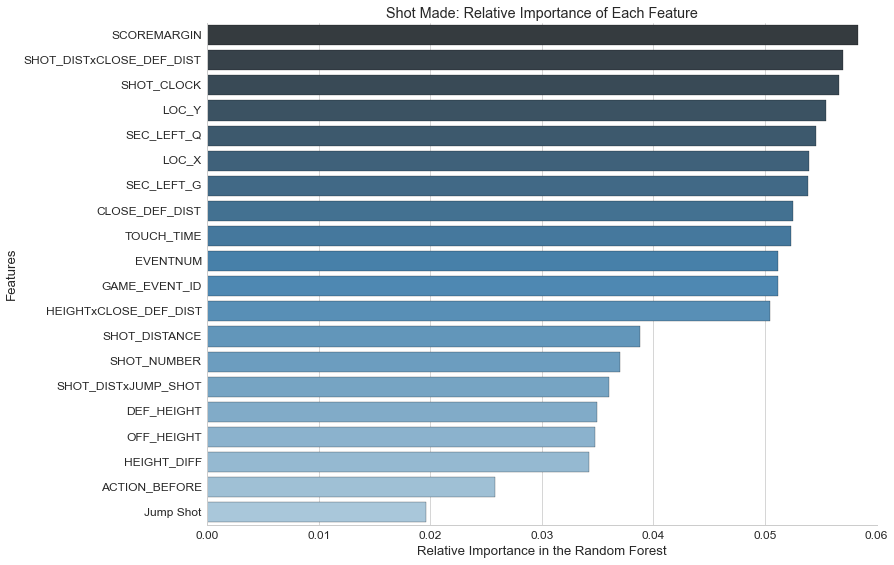

In [38]:
importance_list = clfForest.feature_importances_
name_list = dftouse.columns
importance_list, name_list = zip(*sorted(zip(importance_list, Xnames)))
#full list of features
#ax = sns.barplot(y=range(len(name_list)),x=list(reversed(importance_list)), orient='h', palette="Blues_d")
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(12, 9))
#top 20 features
ax = sns.barplot(y=range(20),x=list(reversed(importance_list))[:20], orient='h', palette="Blues_d")
ax.set_xlabel('Relative Importance in the Random Forest')
ax.set_ylabel('Features')
ax.set_title('Shot Made: Relative Importance of Each Feature')
ax.set_yticklabels(list(reversed(name_list)));
sns.despine()
plt.savefig('Baseline Relative Importance.png', bbox_inches='tight')

In [40]:
df2013_ = df2013.drop('PLAYER_NAME', axis=1)
df2014_ = df2014.drop('PLAYER_NAME', axis=1)
Xtrain2013 = df2013_.ix[:, 1:76]
ytrain2013 = df2013_['SHOT_MADE_FLAG']
Xtest2014 = df2014_.ix[:, 1:76]

Here we compute our accuracy on the 2014 data.  We split this earlier, so this is 100% testing data

In [41]:
%%time
clfForest.fit(Xtrain2013, ytrain2013)

CPU times: user 9min 17s, sys: 8.8 s, total: 9min 25s
Wall time: 9min 27s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
%%time
predictions = clfForest.predict_proba(Xtest2014)

CPU times: user 1min 18s, sys: 16 s, total: 1min 34s
Wall time: 1min 50s


In [44]:
MSE = np.average([(x-y)**2 for x,y in zip(df2014.SHOT_MADE_FLAG,df2014.pred)])
print 'MSE: ' + str(MSE)

MSE: 0.210947492036


In [45]:
Accuracy = np.average([1 if (x-.5)*(y-.5)>0 else 0 for x,y in zip(df2014.SHOT_MADE_FLAG,df2014.pred)])
print 'Accuracy: ' + str(Accuracy)

Accuracy: 0.662909257503


One last thing we can do is see if our results match up with what we did in Book_1, when we found the players that average the most expected points per play and those that score the most above the expected. We are using the same code and doing this below.

In [47]:
df2014['pred']=[x[1] for x in predictions]
df2014['resid']=(df2014.SHOT_MADE_FLAG-df2014.pred)*df2014.PTS_TYPE
players=list(set(df2014['PLAYER_NAME']))
pct_above=[]
predpps=[]
count=[]
players_act=[]
for player in players:
    subset=df2014[df2014['PLAYER_NAME']==player]
    if len(subset.index)>100:
        players_act.append(player)
        pct_above.append(np.average(subset.resid))
        predpps.append(np.average(subset.pred*subset.PTS_TYPE))
        count.append(len(subset.index))

/Users/raymondcen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/raymondcen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [46]:
comb=zip(players_act,pct_above,predpps,count)
comb.sort(key=lambda tup: tup[1],reverse=True)
comb

[('Luke Babbitt', 0.27951381215469617, 0.99672928176795583, 181),
 ('Kyle Korver', 0.20693490054249547, 1.123987341772152, 553),
 ('Andre Miller', 0.19087644787644786, 0.84001158301158296, 259),
 ('Damjan Rudez', 0.17547410358565735, 0.99982470119521916, 251),
 ('Ed Davis', 0.16279274611398964, 1.1066373056994818, 386),
 ('Chris Paul', 0.16121532846715328, 0.94553649635036496, 1096),
 ('George Hill', 0.1557789256198347, 0.93513016528925619, 484),
 ('Al Jefferson', 0.14578578892371996, 0.83540543364681286, 957),
 ('CJ Watson', 0.14404986876640419, 0.94781364829396331, 381),
 ('Carl Landry', 0.13765242165242167, 0.91078062678062688, 351),
 ('TJ Warren', 0.13265346534653466, 0.9911089108910891, 202),
 ('Hedo Turkoglu', 0.12743406593406595, 1.0923461538461539, 182),
 ('Anthony Morrow', 0.12267652173913041, 1.0547147826086958, 575),
 ('Ben Gordon', 0.12222097378277152, 0.91523220973782782, 267),
 ('Jose Calderon', 0.11871005917159762, 0.86057988165680466, 338),
 ('David West', 0.11528247734

This list is extremely similar to the one we got before, suggesting that the two methods produce similar results.

That is all for this notebook and for the project, thanks for reading!